# ALM_R&S_Quantitative Assignment 
### Qinyan Wu

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from scipy.spatial import distance
import statsmodels.tsa.stattools as stattools
import datetime


## Step 1: Query and retrieve data series

#####  Store data series in a DataFrame

In [2]:
from fredapi import Fred
fred = Fred(api_key='afb7a033c2ee392aad3ddda3f3c70362')
tags=['GS1','GS2','GS3','GS5','GS7','GS10']
adict={}
for tag in tags:

    key=tag
    series=fred.get_series(tag)
    adict[key]=series
data=pd.DataFrame(adict)
data.head()

,GS1,GS2,GS3,GS5,GS7,GS10
1953-04-01,2.36,NaN,2.51,2.62,NaN,2.83
1953-05-01,2.48,NaN,2.72,2.87,NaN,3.05
1953-06-01,2.45,NaN,2.74,2.94,NaN,3.11
1953-07-01,2.38,NaN,2.62,2.75,NaN,2.93
1953-08-01,2.28,NaN,2.58,2.80,NaN,2.95


#####  Handle missing values 

In [3]:
data.describe()

,GS1,GS2,GS3,GS5,GS7,GS10
count,823.000000,545.000000,823.000000,823.000000,628.000000,823.000000
mean,4.676063,5.078587,5.080814,5.329392,5.990478,5.640863
std,3.321627,3.811277,3.213891,3.097340,3.257417,2.921757
min,0.050000,0.120000,0.160000,0.270000,0.460000,0.620000
25%,2.180000,1.580000,2.600000,2.930000,3.205000,3.550000
50%,4.470000,4.960000,4.740000,4.910000,6.150000,5.090000
75%,6.415000,7.570000,6.975000,7.175000,7.920000,7.425000
max,16.720000,16.460000,16.220000,15.930000,15.650000,15.320000


In [30]:
data.dropna(inplace=True)
data.head()

,GS1,GS2,GS3,GS5,GS7,GS10
1976-06-01,6.52,7.06,7.31,7.61,7.75,7.86
1976-07-01,6.20,6.85,7.12,7.49,7.70,7.83
1976-08-01,6.00,6.63,6.86,7.31,7.58,7.77
1976-09-01,5.84,6.42,6.66,7.13,7.41,7.59
1976-10-01,5.50,5.98,6.24,6.75,7.16,7.41


## Step 2: Reduce Dimensions by PCA

#### Create new data for  monthly changes

In [5]:
monthly_change=data.shift(-1)-data
monthly_change.dropna(inplace=True)
monthly_change.head()

,GS1,GS2,GS3,GS5,GS7,GS10
1976-06-01,-0.32,-0.21,-0.19,-0.12,-0.05,-0.03
1976-07-01,-0.20,-0.22,-0.26,-0.18,-0.12,-0.06
1976-08-01,-0.16,-0.21,-0.20,-0.18,-0.17,-0.18
1976-09-01,-0.34,-0.44,-0.42,-0.38,-0.25,-0.18
1976-10-01,-0.21,-0.17,-0.15,-0.23,-0.30,-0.12


### PCA analysis

##### Standardize data

In [6]:
standard= scale(monthly_change)
monthly_change= pd.DataFrame(standard, index=monthly_change.index, columns=monthly_change.columns)
monthly_change.head()

,GS1,GS2,GS3,GS5,GS7,GS10
1976-06-01,-0.711055,-0.499901,-0.477856,-0.316034,-0.119308,-0.061234
1976-07-01,-0.434216,-0.525182,-0.665994,-0.491525,-0.337209,-0.160770
1976-08-01,-0.341936,-0.499901,-0.504733,-0.491525,-0.492853,-0.558912
1976-09-01,-0.757195,-1.081360,-1.096025,-1.076494,-0.741883,-0.558912
1976-10-01,-0.457286,-0.398777,-0.370348,-0.637767,-0.897527,-0.359841


##### Implement PCA

In [7]:
pca=PCA().fit(monthly_change)

In [8]:
def pca_summary(pca, standardised_data, out=True):
     names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
     a = list(np.std(pca.transform(standardised_data), axis=0))
     b = list(pca.explained_variance_ratio_)
     c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, 
     len(pca.explained_variance_ratio_)+1)]
     columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", 
    "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
     summary = pd.DataFrame(zip(a, b, c), index=names, columns=columns)
     if out:
         print("Importance of components:")
         display(summary)
     return summary

In [9]:
summary = pca_summary(pca, monthly_change)

Importance of components:


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,2.372321,0.937984,0.937984
PC2,0.567345,0.053647,0.991631
PC3,0.181554,0.005494,0.997125
PC4,0.098589,0.001620,0.998745
PC5,0.064859,0.000701,0.999446
PC6,0.057673,0.000554,1.000000


##### Cumulative propotion of  Variance and Proportion of Variance 

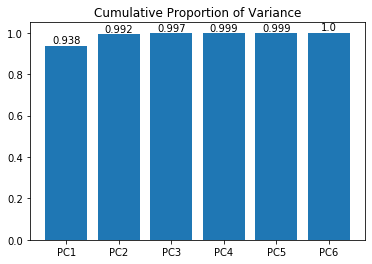

In [10]:
x1=summary.index
y=summary['cumprop'].values.reshape(-1)
plt.bar(x1, y)
plt.title("Cumulative Proportion of Variance")
for xx, yy in zip(x1,y):
    plt.text(xx, yy+0.01, str(round(yy,3)), ha='center')
plt.show()

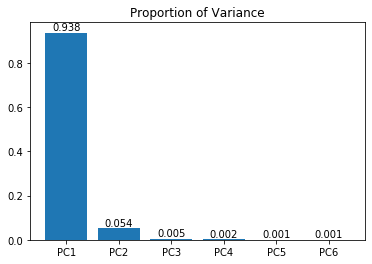

In [11]:
x=summary.index
y=summary['varprop'].values.reshape(-1)
plt.bar(x, y)
plt.title("Proportion of Variance")
for xx, yy in zip(x,y):
    plt.text(xx, yy+0.01, str(round(yy,3)), ha='center')
plt.show()

##### Reduce the dimension to three

In [12]:
PCA_dict={}
for i in range(3):
    PCA_dict['PC'+str(i+1)]=pca.transform(monthly_change)[:,i]
PCA_data=pd.DataFrame(PCA_dict,index=monthly_change.index)
PCA_data

,PC1,PC2,PC3
1976-06-01,0.888255,0.551753,-0.026462
1976-07-01,1.072054,0.234299,-0.277551
1976-08-01,1.181941,-0.116526,-0.033573
1976-09-01,2.176907,0.213209,-0.411894
1976-10-01,1.276016,-0.181139,0.011477
...,...,...,...
2021-05-01,-0.047663,-0.297289,0.287381
2021-06-01,0.445259,-0.604298,0.302898
2021-07-01,-0.041594,-0.057176,0.116003
2021-08-01,-0.525342,0.283810,-0.021088


### Test the stationarity of data after PCA

#####   Time series plotting

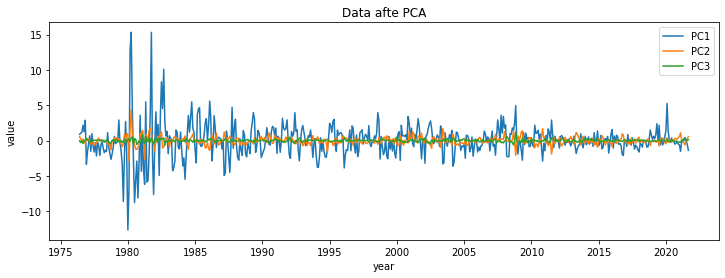

In [13]:
plt.figure(figsize=(12,4))
for i in PCA_data.columns:
    plt.plot(PCA_data[i],label=i)
plt.legend()
plt.xlabel("year")
plt.ylabel("value")
plt.title("Data afte PCA")
plt.show()

##### Autocorrelation  and Partial Autocorrelation 

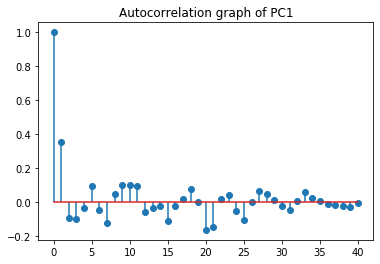

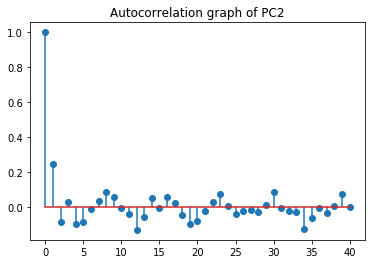

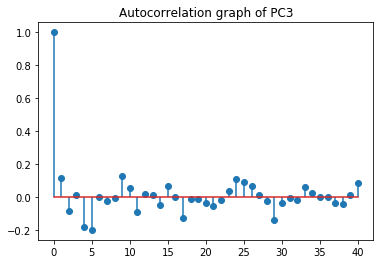

In [14]:
for i in PCA_data.columns:
    plt.title("Autocorrelation graph of "+i)
    plt.stem(stattools.acf(PCA_data[i],fft=False),use_line_collection=True)
    plt.show()

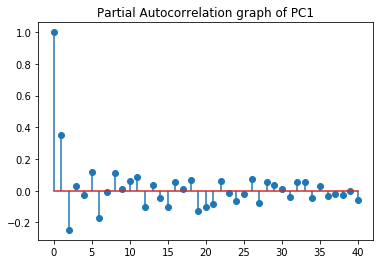

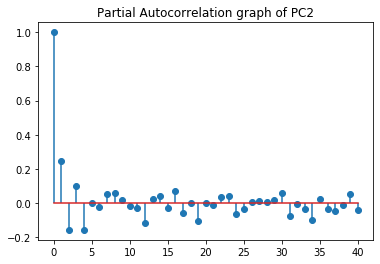

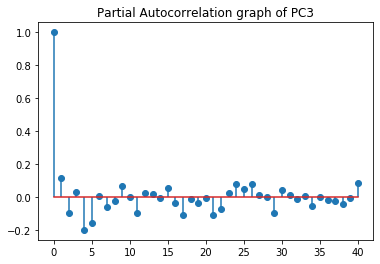

In [15]:
for i in PCA_data.columns:
    plt.title("Partial Autocorrelation graph of "+i)
    plt.stem(stattools.pacf(PCA_data[i]),use_line_collection=True)
    plt.show()

##### Augmented Dickey-Fuller test

In [16]:
def ADF_test(data):
    print("Augmented Dickey-Fuller test:")
    for i in data.columns:
        print(i,":")
        X = data[i].values
        result = adfuller(X)
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))

In [17]:
ADF_test(PCA_data)

Augmented Dickey-Fuller test:
PC1 :
ADF Statistic: -5.851463
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570
PC2 :
ADF Statistic: -12.658412
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570
PC3 :
ADF Statistic: -14.160536
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


## Step3: Similarity Matching in Time Series

### Dynamic Time Warping analysis

In [18]:
monthly_change.head()

,GS1,GS2,GS3,GS5,GS7,GS10
1976-06-01,-0.711055,-0.499901,-0.477856,-0.316034,-0.119308,-0.061234
1976-07-01,-0.434216,-0.525182,-0.665994,-0.491525,-0.337209,-0.160770
1976-08-01,-0.341936,-0.499901,-0.504733,-0.491525,-0.492853,-0.558912
1976-09-01,-0.757195,-1.081360,-1.096025,-1.076494,-0.741883,-0.558912
1976-10-01,-0.457286,-0.398777,-0.370348,-0.637767,-0.897527,-0.359841


In [29]:
# Choosing the time series data in Sep 2020 to Sep 2021 as sample time series data
# The taget is to find the a period of time when monthly-changing data is similar to the sample time series data
sample_data.shape

(13, 3)

In [31]:
start=datetime.datetime(1976,6,1)
end=datetime.datetime(2020,9,1)
#DTW_data=monthly_change[start:end]
DTW_data=PCA_data[start:end]
DTW_data.head()

,PC1,PC2,PC3
1976-06-01,0.888255,0.551753,-0.026462
1976-07-01,1.072054,0.234299,-0.277551
1976-08-01,1.181941,-0.116526,-0.033573
1976-09-01,2.176907,0.213209,-0.411894
1976-10-01,1.276016,-0.181139,0.011477


##### Build rolling windows 

In [21]:

Years=[]
for i in range(len(DTW_data)-12):
    Years.append(DTW_data[i:i+13])
len(Years)

520

##### Compute distance matrices

In [22]:
# For each time period, compute the distance matrix of it and the sample data
DistMatrixdict={}
for i in Years:
    key=i.index[0]
    value=distance.cdist(i,sample_data,metric='euclidean')
    DistMatrixdict[key]=value

##### Dynamic Time Warping model

In [23]:
def DTW(dist_mat):
    N=dist_mat.shape[0]
    M=dist_mat.shape[1]
    
    # Initialize the cost matrix
    cost_mat=np.zeros((N+1,M+1))
    for i in range(1,N+1):
        cost_mat[i,0]=np.inf
    for j in range(1,M+1):
        cost_mat[0,j]=np.inf
        
    # Initialize the track matrix
    trac_mat=np.zeros((N,M))
    for i in range(0,N):
        for j in range(0,M):
            action=[cost_mat[i,j],cost_mat[i,j+1],cost_mat[i+1,j]]
            act=np.argmin(action)
            trac_mat[i,j]=act
            cost_mat[i+1,j+1]=action[act]+dist_mat[i,j]
    
    # Traceback from end to the original point
    i=N-1
    j=M-1
    path=[(i,j)]
    while i>0 or j>0:
        trac_type=trac_mat[i,j]
        if trac_type==0:
            i=i-1
            j=j-1
        elif trac_type==1:
            i=i-1
        elif trac_type==2:
            j=j-1
        path.append((i,j))
        #print(path)
    # Delete extra edges    
    cost_mat=cost_mat[1:,1:]
    return(path[::-1],cost_mat)

##### Find the most similar time series data according to matching costs

In [24]:
# The time period most similar with the sample data will have the minimum matching cost
Matching_cost={}
cost_matrix={}
for k,j in DistMatrixdict.items():
    path, cost_mat = DTW(j)
    N=Years[1].shape[0]
    M=sample_data.shape[0]
    value=cost_mat[N - 1, M - 1]
    Matching_cost[k]=value
    cost_matrix[k]=cost_mat
    min_begin_year=min(Matching_cost,key=Matching_cost.get)
print("The minimum mathcing cost: ",Matching_cost[min_begin_year])
print("The most similar period:",min_begin_year.date(),"to",min_begin_year.date()+pd.Timedelta(365,unit='days'))

The minimum mathcing cost:  7.091748899941251
The most similar period: 2012-07-01 to 2013-07-01


##### Warping path identification

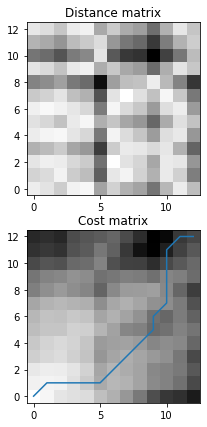

In [27]:
# Display the warping path of DTW 
dist_mat=DistMatrixdict[min_begin_year]
cost_mat=cost_matrix[min_begin_year]
plt.figure(figsize=(8, 7))
plt.subplot(211)
plt.title("Distance matrix")
plt.imshow(dist_mat, cmap=plt.cm.binary, interpolation="nearest", origin="bottom")
plt.subplot(212)
plt.title("Cost matrix")
plt.imshow(cost_mat, cmap=plt.cm.binary, interpolation="nearest", origin="bottom")
x_path, y_path = zip(*path)
plt.plot(y_path, x_path);

##### Compare similar time series and sample series

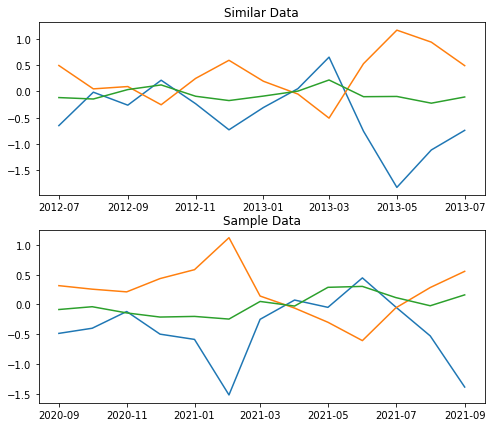

In [26]:
similar_data=PCA_data.loc['2012-07-01':'2013-07-01']
plt.figure(figsize=(8, 7))
plt.subplot(211)
plt.title("Similar Data")
plt.plot(similar_data)
plt.subplot(212)
plt.title("Sample Data")
plt.plot(sample_data)
plt.show()

##### As shown in the graph, the two time series data obtain similar patterns roughly